In [1]:
import pandas as pd
# Read data files
lot = pd.read_csv('Downloads/Parcel_Land_Sizes.csv')
sales = pd.read_csv('Downloads/Parcel_Sales_History.csv')
vars = pd.read_csv('Downloads/Residential_Dwelling_Characteristics.csv')
print(lot.shape, sales.shape, vars.shape)

c:\users\xjin\miniconda3\envs\capstone\lib\site-packages\IPython\core\interactiveshell.py:3049: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


(626881, 13) (334751, 14) (365599, 21)


In [2]:
# Convert sale date from string to date
sales['Date'] = pd.to_datetime(sales['Sale Date'], format= "%B %d %Y")
# Get the last sale for each property
idx = sales.groupby(['Assessment Account Number'])['Date'].transform(max) == sales['Date']
sales2 = sales[idx]
print(sales2.shape)

(233640, 15)


In [3]:
# Select sales from Halifax and sales value not zero
sales_halifax = sales2[sales2['Civic City Name'] == 'HALIFAX']
sales_halifax = sales_halifax[sales_halifax['Sale Price'] > 0]
print(sales_halifax.shape)

(14166, 15)


[[<matplotlib.axes._subplots.AxesSubplot object at 0x0000018C93C9BF28>]]


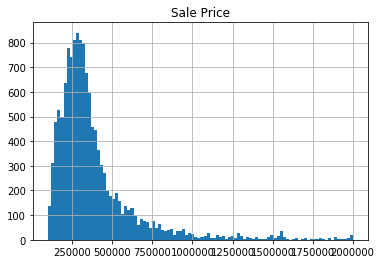

In [5]:
%matplotlib inline
import numpy as np
# Filter out extreme sales values
# sales3 = sales_halifax[((sales_halifax['Sale Price'] - sales_halifax['Sale Price'].mean()) / sales_halifax['Sale Price'].std()).abs() < 1]
prices = sales_halifax['Sale Price']
idx2 = prices.between(prices.quantile(.03), prices.quantile(.97)) 
sales3 = sales_halifax[idx2]
print(sales3.hist(column='Sale Price', bins=100))

c:\users\xjin\miniconda3\envs\capstone\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


[[<matplotlib.axes._subplots.AxesSubplot object at 0x0000018C8797CF60>]]


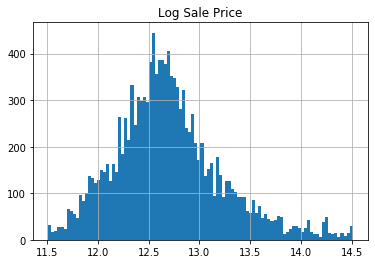

In [6]:
sales3['Log Sale Price'] = np.log(sales3['Sale Price'])
print(sales3.hist(column='Log Sale Price', bins=100))

In [7]:
# Joining property characteristics to the table
sales3 = sales3.set_index('Assessment Account Number')
lot3 = lot.set_index('Assessment Account Number')
vars3 = vars.set_index('Assessment Account Number')
print(sales3.shape)
data = sales3.join(lot3, how='inner', lsuffix='_sale', rsuffix='_lot')
print(data.shape)
data = data.join(vars3, how='inner', lsuffix='_data', rsuffix='_vars')
print(data.shape)

(13322, 15)
(13322, 27)
(12303, 47)


In [8]:
# Select only columns needed for modelling and rename them
print(data.columns)
data = data[data['Under Construction'] != 'Y']
print(data.shape)
cols = ['Sale Price', 'Date', 'Square Feet', 'Living Units', 'Year Built', 
        'Square Foot Living Area', 'Style', 'Bedrooms', 'Bathrooms', 
        'Construction Grade','Finished Basement', 
        'Garage', 'Y Map Coordinate', 'X Map Coordinate']
data2 = data[cols]
colnames = ['price', 'date', 'lot', 'units', 'year', 
        'area', 'style', 'bedrooms', 'bathrooms', 
        'grade','basement', 
        'garage', 'lat', 'lon']
data2.columns = colnames
data2.head()

Index(['Municipal Unit_sale', 'Civic Number_sale', 'Civic Additional_sale',
       'Civic Direction_sale', 'Civic Street Name_sale', 'Civic Suffix',
       'Civic City Name_sale', 'Sale Price', 'Sale Date', 'Parcels In Sale',
       'Y Map Coordinate_sale', 'X Map Coordinate_sale',
       'Map Coordinates_sale', 'Date', 'Log Sale Price', 'Municipal Unit_lot',
       'Civic Number_lot', 'Civic Additional_lot', 'Civic Direction_lot',
       'Civic Street Name_lot', 'Civic Street Suffix_data',
       'Civic City Name_lot', 'Acreage', 'Square Feet', 'Y Map Coordinate_lot',
       'X Map Coordinate_lot', 'Map Coordinates_lot', 'Municipal Unit',
       'Civic Number', 'Civic Additional', 'Civic Direction',
       'Civic Street Name', 'Civic Street Suffix_vars', 'Civic City Name',
       'Living Units', 'Year Built', 'Square Foot Living Area', 'Style',
       'Bedrooms', 'Bathrooms', 'Under Construction', 'Construction Grade',
       'Finished Basement', 'Garage', 'Y Map Coordinate', 'X Map C

,price,date,lot,units,year,area,style,bedrooms,bathrooms,grade,basement,garage,lat,lon
Assessment Account Number,,,,,,,,,,,,,,
5738,263000.0,2015-07-29,8756.0,1,1962.0,2022.0,Split Level,2.0,3,Average,Y,N,44.66591,-63.63947
6297,430000.0,2013-07-08,5900.0,2,1948.0,1665.0,2 Storey,2.0,2,Good,N,Y,44.63852,-63.62705
6432,680000.0,2015-08-12,1191.0,1,1989.0,1958.0,2 Storey,3.0,3,Good,Y,N,44.64065,-63.57655
6521,265000.0,2011-12-09,3400.0,1,1918.0,1266.0,2 Storey,3.0,1,Good,N,N,44.66343,-63.60754
6726,536000.0,2016-01-05,8990.0,1,1950.0,2996.0,2 Storey,4.0,7,Good,Y,N,44.64284,-63.60481


In [9]:
# data description
data2.describe()

,price,lot,units,year,area,bedrooms,bathrooms,lat,lon
count,1.220200e+04,9.604000e+03,12202.000000,10952.000000,8455.000000,11484.000000,12202.000000,11279.000000,11279.000000
mean,3.520831e+05,7.913729e+03,1.112686,1976.783692,1976.009462,3.053379,2.221439,44.436123,-63.315489
std,2.075238e+05,2.554868e+05,0.494048,31.603389,828.873176,1.212661,1.106629,3.082262,4.391802
min,1.000000e+05,0.000000e+00,0.000000,1555.000000,300.000000,0.000000,0.000000,0.000000,-63.690940
25%,2.299000e+05,3.003000e+03,1.000000,1953.000000,1420.000000,2.000000,1.000000,44.636545,-63.641170
50%,3.030000e+05,4.327500e+03,1.000000,1985.000000,1829.000000,3.000000,2.000000,44.650460,-63.615040
75%,4.027175e+05,6.400000e+03,1.000000,2005.000000,2334.000000,4.000000,3.000000,44.663920,-63.597110
max,2.000000e+06,2.500230e+07,12.000000,2018.000000,8389.000000,17.000000,12.000000,44.705250,0.000000


In [12]:
# remove zero values in lot, units, bedrooms, bathrooms, lat
data3 = data2[(data2.lot > 0) & (data2.units > 0) & (data2.units < 2)
& (data2.bedrooms > 0) & (data2.bathrooms > 0) & (data2.lat > 0)]
data3 = data3.dropna()
print(data3.shape)
data3.describe()

(5938, 14)


,price,lot,units,year,area,bedrooms,bathrooms,lat,lon
count,5.938000e+03,5.938000e+03,5938.0,5938.000000,5938.000000,5938.000000,5938.000000,5938.000000,5938.000000
mean,3.683752e+05,6.368817e+03,1.0,1969.276187,1918.777871,3.277703,2.439879,44.648214,-63.625931
std,2.032581e+05,1.785889e+04,0.0,31.541928,820.205388,0.818667,1.062716,0.024159,0.026701
min,1.000000e+05,2.330000e+02,1.0,1555.000000,399.000000,1.000000,1.000000,44.585760,-63.690940
25%,2.500000e+05,3.575000e+03,1.0,1945.000000,1364.000000,3.000000,2.000000,44.632070,-63.646095
50%,3.159530e+05,5.000000e+03,1.0,1964.000000,1759.000000,3.000000,2.000000,44.648970,-63.619005
75%,4.160000e+05,7.021500e+03,1.0,2002.000000,2235.000000,4.000000,3.000000,44.665397,-63.606965
max,2.000000e+06,1.064171e+06,1.0,2018.000000,8389.000000,8.000000,7.000000,44.704890,-63.563700


In [13]:
data3.describe(exclude=[np.number])

,date,style,grade,basement,garage
count,5938,5938,5938,5938,5938
unique,1860,18,6,2,2
top,2018-06-28 00:00:00,2 Storey,Average,Y,N
freq,18,2473,4269,3948,3302
first,2010-07-02 00:00:00,NaN,NaN,NaN,NaN
last,2019-05-30 00:00:00,NaN,NaN,NaN,NaN


In [14]:
# Compute additional variables - age, year of sale, and logprice
data3['age'] = 2019 - data3['year']
data3['yearsale'] = pd.DatetimeIndex(data3['date']).year
data3['logprice'] = np.log(data3['price'])
data4 = data3[data3['yearsale'] > 2009]
print(data4.yearsale.value_counts())


2018    886
2017    810
2016    718
2012    694
2015    611
2011    570
2014    558
2013    549
2010    274
2019    268
Name: yearsale, dtype: int64


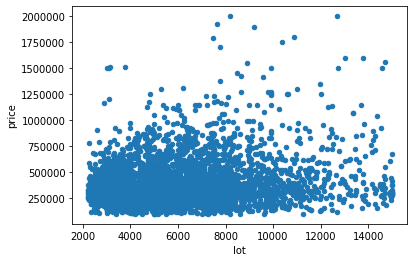

In [17]:
lot = data4['lot']
idx3 = lot.between(lot.quantile(.03), lot.quantile(.97)) 
data41 = data4[idx3]
data41.plot.scatter('lot','price')

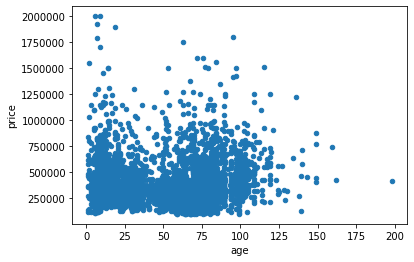

In [19]:
data42 = data41[data41['age'] < 200]
data42.plot.scatter('age', 'price')

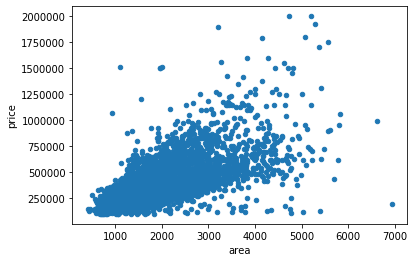

In [20]:
data42.plot.scatter('area','price')

In [21]:
print(data42.columns)

Index(['price', 'date', 'lot', 'units', 'year', 'area', 'style', 'bedrooms',
       'bathrooms', 'grade', 'basement', 'garage', 'lat', 'lon', 'age',
       'yearsale', 'logprice'],
      dtype='object')


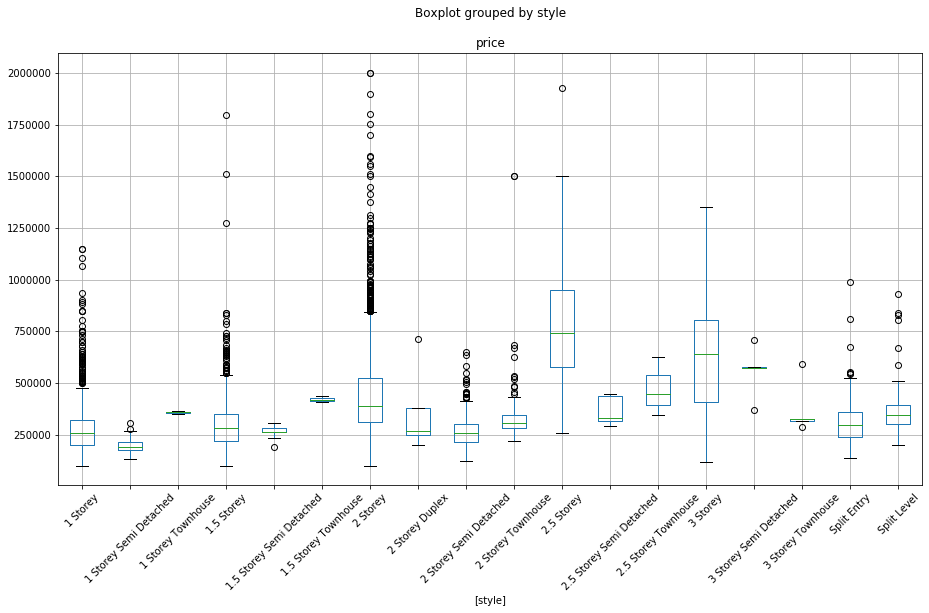

In [35]:
data42.boxplot(column=['price'],by=['style'],rot=45, figsize=(15,8))

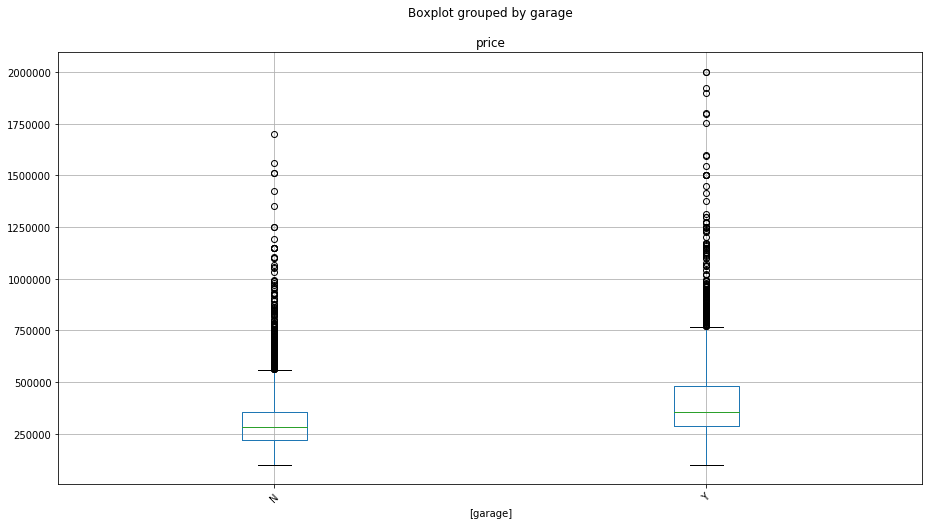

In [41]:
data42.boxplot(column=['price'],by=['garage'],rot=45, figsize=(15,8))

In [42]:
# Get random 900 sales from the list
data5 = data4.sample(900, random_state=0)
print(data5.shape)
data5 = data5.drop(['date', 'units', 'year', 'price'], axis=1)
data5 = data5.dropna()
print(data5.columns)

(900, 17)
Index(['lot', 'area', 'style', 'bedrooms', 'bathrooms', 'grade', 'basement',
       'garage', 'lat', 'lon', 'age', 'yearsale', 'logprice'],
      dtype='object')


In [49]:
# One hot encoding for categorical variables
X = data5.drop(['logprice','lat','lon','yearsale','bedrooms'
                ,'basement','age','lot'], axis=1)
y = data5['logprice']
print(X.columns)

X = pd.get_dummies(X, columns=['bathrooms', 'style', 'garage',
                               'grade'], drop_first=True)
print(X.columns)

Index(['area', 'style', 'bathrooms', 'grade', 'garage'], dtype='object')
Index(['area', 'bathrooms_2', 'bathrooms_3', 'bathrooms_4', 'bathrooms_5',
       'bathrooms_6', 'style_1 Storey Semi Detached',
       'style_1 Storey Townhouse', 'style_1.5 Storey', 'style_2 Storey',
       'style_2 Storey Duplex', 'style_2 Storey Semi Detached',
       'style_2 Storey Townhouse', 'style_2.5 Storey',
       'style_2.5 Storey Semi Detached', 'style_2.5 Storey Townhouse',
       'style_3 Storey', 'style_3 Storey Townhouse', 'style_Split Entry',
       'style_Split Level', 'garage_Y', 'grade_Fair', 'grade_Good',
       'grade_Low', 'grade_Very Good'],
      dtype='object')


In [50]:
# Feature selection
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE
from sklearn.metrics import r2_score
lr = LinearRegression()
rfe = RFE(lr)
rfe.fit(X, y)
print(sorted(zip(map(lambda x: round(x, 4), rfe.ranking_), X.columns)))
lr.fit(X, y)
pred = lr.predict(X)
r2_score(y, pred)
# to select
# bathroom, grade, age, area, lot


[(1, 'bathrooms_4'), (1, 'bathrooms_5'), (1, 'grade_Fair'), (1, 'grade_Good'), (1, 'grade_Low'), (1, 'grade_Very Good'), (1, 'style_1 Storey Semi Detached'), (1, 'style_2 Storey Duplex'), (1, 'style_2 Storey Semi Detached'), (1, 'style_2.5 Storey'), (1, 'style_2.5 Storey Semi Detached'), (1, 'style_3 Storey'), (2, 'bathrooms_3'), (3, 'bathrooms_6'), (4, 'bathrooms_2'), (5, 'style_2 Storey'), (6, 'style_Split Level'), (7, 'style_1.5 Storey'), (8, 'style_2.5 Storey Townhouse'), (9, 'garage_Y'), (10, 'style_2 Storey Townhouse'), (11, 'style_1 Storey Townhouse'), (12, 'style_3 Storey Townhouse'), (13, 'style_Split Entry'), (14, 'area')]


0.6052350568524363

In [105]:
# Use foursquare API to get nearby venues
import requests

CLIENT_ID = 'xxx' # your Foursquare ID
CLIENT_SECRET = 'xxx' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

{'meta': {'code': 200, 'requestId': '5d177d886f0aa2002cb47bf0'},
 'response': {'venues': [{'id': '42829c80f964a5206a221fe3',
    'name': 'Grand Central Terminal',
    'location': {'address': '87 E 42nd St',
     'crossStreet': 'btwn Vanderbilt & Park Ave',
     'lat': 40.75269007041951,
     'lng': -73.97724935455403,
     'distance': 14235,
     'postalCode': '10017',
     'cc': 'US',
     'city': 'New York',
     'state': 'NY',
     'country': 'United States',
     'formattedAddress': ['87 E 42nd St (btwn Vanderbilt & Park Ave)',
      'New York, NY 10017',
      'United States']},
    'categories': [{'id': '4bf58dd8d48988d129951735',
      'name': 'Train Station',
      'pluralName': 'Train Stations',
      'shortName': 'Train Station',
      'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/travel/trainstation_',
       'suffix': '.png'},
      'primary': True}],
    'venuePage': {'id': '91385129'},
    'referralId': 'v-1561820552',
    'hasPerk': False},
   {'id': '4c83f3

In [51]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            100)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [107]:
halifax_venues = getNearbyVenues(names=data5['lat'],
                                 latitudes=data5['lat'],
                                 longitudes=data5['lon'])

44.65038
44.627759999999995
44.58979
44.67541
44.64758
44.60557
44.64714
44.636309999999995
44.64869
44.64394
44.67824
44.66455
44.66807
44.6952
44.66714
44.6448
44.62278
44.64362
44.670590000000004
44.629509999999996
44.69748
44.6352
44.67655
44.67029
44.62632
44.65146
44.67848
44.63482
44.6102
44.63923
44.63109
44.62099
44.6336
44.64877
44.634409999999995
44.6668
44.65372
44.65361
44.60785
44.64143
44.64034
44.65417
44.68712
44.66015
44.6314
44.63399999999999
44.615990000000004
44.63281
44.63238
44.620540000000005
44.66186
44.61408
44.63803
44.64105
44.61117
44.65627
44.60405
44.62935
44.6522
44.6413
44.65875
44.67541
44.65397
44.60865
44.60823
44.61781
44.678329999999995
44.66717
44.64417
44.6583
44.662009999999995
44.64123
44.611090000000004
44.6297
44.5891
44.67966
44.69279
44.69249
44.66853
44.69182
44.60415
44.64356
44.63705
44.66067
44.659420000000004
44.66667
44.647529999999996
44.63399999999999
44.60277
44.63179
44.665
44.66891
44.670559999999995
44.613279999999996
44.61907
4

In [109]:
import pickle
pickle.dump(halifax_venues, open('halifax_venues.pickle','wb'))


In [120]:
venue_counts = halifax_venues.groupby(['Neighborhood Latitude','Neighborhood Longitude']).count()

data_venue = data5.merge(venue_counts, how='left', left_on=['lat','lon'],
                        right_on=['Neighborhood Latitude','Neighborhood Longitude'])

In [125]:
print(data_venue.shape)
print(data_venue.head())
print(data_venue.columns)
data_use = data_venue.dropna()
print(data_use.shape)
# ['lot', 'area', 'style', 'bedrooms', 'bathrooms', 'grade', 
# 'basement', 'garage', 'lat', 'lon', 'age', 'yearsale', 
# 'logprice', 'Neighborhood', 'Venue', 'Venue Latitude', 
# 'Venue Longitude', 'Venue Category'],

(840, 18)
      lot    area                     style  bedrooms  bathrooms    grade  \
0  2640.0  1464.0  2.5 Storey Semi Detached       3.0          2  Average   
1  3300.0  1056.0                1.5 Storey       3.0          1  Average   
2  9956.0  2142.0                  1 Storey       3.0          3  Average   
3  6999.0  2053.0                  1 Storey       3.0          2     Fair   
4  3084.0  2496.0        2 Storey Townhouse       3.0          3  Average   

  basement garage       lat       lon   age  yearsale   logprice  \
0        N      N  44.65038 -63.60283  89.0      2015  12.706848   
1        N      N  44.62776 -63.57697  73.0      2012  12.877741   
2        Y      Y  44.58979 -63.59486  16.0      2012  12.013701   
3        Y      N  44.67541 -63.65502  62.0      2017  12.363076   
4        Y      Y  44.64758 -63.65479  10.0      2014  12.782405   

   Neighborhood  Venue  Venue Latitude  Venue Longitude  Venue Category  
0           5.0    5.0             5.0      

In [70]:
data_use.Venue.value_counts()

4.0     167
3.0      84
5.0      82
2.0      77
1.0      74
6.0      53
7.0      40
8.0      33
10.0     21
9.0      20
15.0     17
14.0     14
12.0     13
11.0     11
13.0      8
25.0      8
17.0      8
33.0      8
16.0      8
24.0      7
31.0      6
23.0      6
22.0      5
28.0      4
21.0      4
18.0      4
20.0      4
19.0      4
32.0      3
34.0      3
35.0      2
41.0      2
36.0      2
29.0      2
27.0      2
44.0      1
45.0      1
30.0      1
42.0      1
37.0      1
38.0      1
Name: Venue, dtype: int64

In [56]:
import pickle
data_use = pickle.load(open('halifax_final_data.pickle', 'rb'))
data_use.head()
print(data_use.shape)

(812, 19)


In [76]:
# Train test split
from sklearn.model_selection import train_test_split
X = data_use[['area','bathrooms','grade', 'style']]
X = pd.get_dummies(X, columns=['bathrooms', 'grade', 'style'], drop_first=True)
y = data_use[['logprice']]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=200,
                                                    random_state=0)
lr = LinearRegression()
lr.fit(X_train, y_train)
pred = lr.predict(X_test)
print(r2_score(np.exp(y_test),np.exp(pred)))

0.509056988650112


In [77]:
X = data_use[['area','bathrooms','grade', 'style', 'Venue']]
X = pd.get_dummies(X, columns=['bathrooms', 'grade', 'style'], drop_first=True)
y = data_use[['logprice']]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=200,
                                                    random_state=0)
lr = LinearRegression()
lr.fit(X_train, y_train)
pred = lr.predict(X_test)
print(r2_score(np.exp(y_test),np.exp(pred)))

0.5094752877191161
